<a id="top"></a> 
# Modeling Place Fields with Point Process Generalized Linear Models

<div class="ch_header">
    
_**Synopsis**_ 

**Data:** Spike train data recorded in vivo from a place cell in rat hippocampus.

**Goal:** Develop a model that relates the spiking of the neuron to the rat's movement trajectory.

**Tools:** generalized linear model, design matrix, model conversion, model deviance analysis, Akaike's information criterion, maximum likelihood ratio test for nested models, Fisher information, Wald test, time rescaling theorem, Kolmogorov-Smirnov test, model residual analysis

</div>

* [Introduction](#TheIntroduction)
* [Data Viz](#DataViz)
* [Data Analysis](#DataAnalysis)
    1. [Fitting a model](#fitting-a-point-process-model)
    2. [Refining the model](#refining-the-model)
    3. [Comparing and evaluating models](#comparing-and-evaluating-models)    
        a. [Comparing AIC values](#comparing-AIC-values)       
        b. [Maximum likelihood ratio test for nested models](#maximum-likelihood-ratio-test-for-nested-models)      
        c. [Confidence intervals for individual model parameters](#confidence-intervals-for-individual-model-parameters)        
        d. [KS test for model goodness-of-fit](#ks-test-for-model-goodness-of-fit)  
        e. [Residual analysis](#residual-analysis)
    4. [Refining the model (cont...)](#refining-the-model-cont)
    5. [Comparing and evaluating models (cont...)](#comparing-and-evaluating-models-cont)
    6. [Drawing conclusions from the model](#drawing-conclusions-from-the-model)
* [Summary](#the-summary)

<a id="TheIntroduction"></a>
## Introduction

In chapter 8, we used visualization methods and simple interspike interval models to describe the spiking properties of a retinal neuron that was maintained at constant light and environmental conditions. In other words, we examined a neuron that was firing on its own, without any explicit driving stimuli. However, many neuroscience experiments involve stimulating or perturbing a neural system and recording changes in spiking activity of a set of neurons in response to that stimulus. The stimulation may be a simple signal applied directly to the neural system, such as a current pulse injected into a neuron. Or it may be a more complex or abstract stimulus that is sensed in the peripheral nervous system and influences neural activity elsewhere, such as the presentation of a movie composed of a natural scene to an awake animal, inducing activity patterns in primary visual cortex and downstream areas.

This stimulus-response paradigm relates to the important concept of *neural coding*: that statistical features of spiking activity contain information about the stimuli, behaviors, or other biological signals that influence the activity. From a data analysis perspective, we are interested in modeling the relation between these signals and the observed spiking activity. We can do so through a statistical spike train model. Here we explore a useful class of models based on the statistical theory of point processes. We define the models in terms of a Poisson rate function, which defines the instantaneous likelihood of observing a spike at any point in time as a function of a set of covariates. In particular, we use a class of point process models that can be fit by maximum likelihood and whose estimators have multiple optimal properties. These are called generalized linear models (GLMs). We provide some basic statistical ideas to develop intuition about these types of models.

### Case study data

A collaborator has contacted us to discuss a new experiment he has performed. As part of this experiment, he has implanted a small bundle of electrodes in a rat’s hippocampus and trained the rat to perform a simple spatial task: to run back and forth along a linear track. During this task, our collaborator believes he has recorded the spiking activity from a place cell - a cell whose activity is dependent on the position of the rat on the linear track. He has asked us to help characterize these spike train data and support (or refute) the notion that the observed cell is a place cell. He has agreed to provide us with the observed spike train data and the position of the rat as a function of time, recorded during a few minutes of the experiment.

### Goals

Our goal is to characterize the properties of the observed cell as the rat runs back and forth in the linear maze. Spiking activity in these cells is known to relate to other variables, such as the speed and head direction of the rat. Here, we focus on modeling the relation between the rat’s movement trajectory and the observed spiking activity. In doing so, we select a model through an iterative process of model fitting, evaluation, and refinement.

### Tools

In this chapter, we develop a series of generalized linear models. We implement procedures to fit, refine, and compare this series of models. We demonstrate the process of implementing and fitting a Poisson regression model, procedures to evaluate model goodness-of-fit and compare models, and methods to construct confidence intervals for model parameters.

In [1]:
## Set-up

# Import required packages.
import scipy.io as sio
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import rcParams
import statsmodels.genmod.families as sm_glm_fams

# Set defaults for figure size, tight layout, and font size.
%matplotlib inline
rcParams['figure.figsize'] = (12,6)
rcParams['figure.autolayout'] = True
rcParams['font.size'] = 14

<a id="DataViz"></a>
### Visual Inspection


We begin with visual inspection of the data. 

Let’s plot the rat’s movement trajectory as a function of time:

Text(0, 0.5, 'Position [cm]')

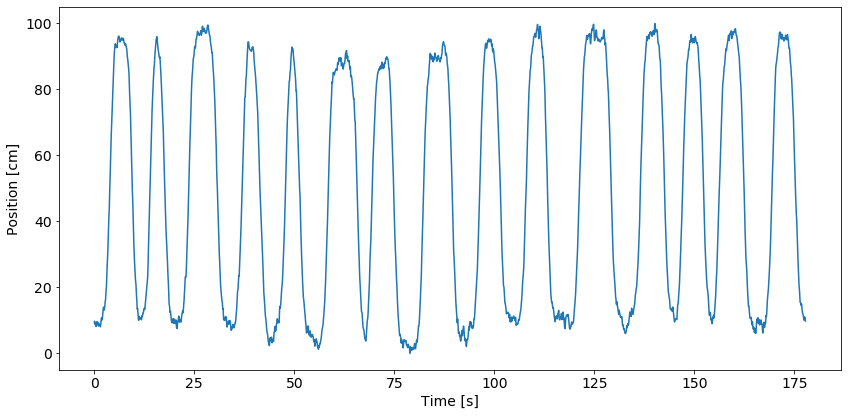

In [2]:
## Get data, reshape as 1-d arrays, and plot position vs. time

data = sio.loadmat('Ch9-spikes-1.mat')  # load the spiking data
t = data['t'].reshape(-1)  # time data
dt = t[1]-t[0]  # sampling rate
x = data['X'].reshape(-1)  # position data 
ts = data['spiketimes'].reshape(-1)  # timestamps of spikes

fig1, ax1 = plt.subplots()
ax1.plot(t, x)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Position [cm]')

The plot shows that the rat runs back and forth consistently, making about 15 passes during the approximately 3 minute recording. We also observe that the rat moves fairly quickly during each back and forth pass but spends a large amount of time at both ends of the track (near position 0 cm or 100 cm) before turning around and continuing.

Next, we would like to plot the spiking activity in relation to the rat’s movement trajectory:

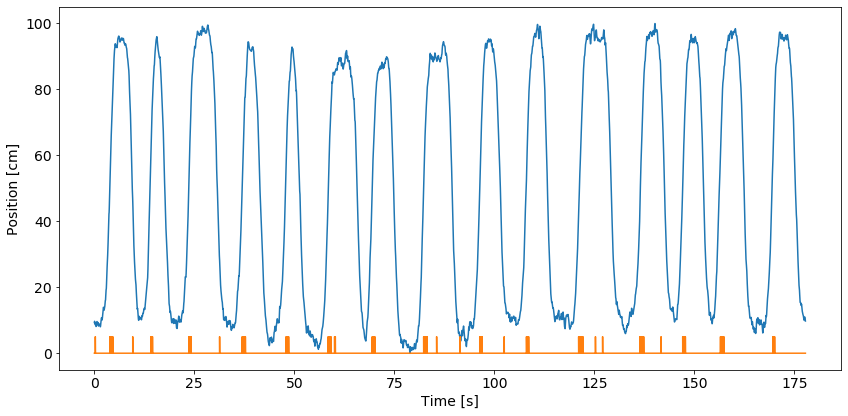

In [3]:
## Plot spiking activity on top of position plot

# Get indices for `t` where a spike occurred.
_, t_spk_idxs, _ = np.intersect1d(t, ts, assume_unique=True, return_indices=True)
# Create a vector of binary values of same size as `t` to indicate if a spike occurred at that time-step.
t_where_spks = np.zeros(t.size)
t_where_spks[t_spk_idxs] = 1
# Plot this vector on top of the position plot.
ax1.plot(t, 5 * t_where_spks)
fig1

We can better visualize the spiking activity and position by indicating the times and positions of the spikes as red dots overlaid onto the position vs. time plot:

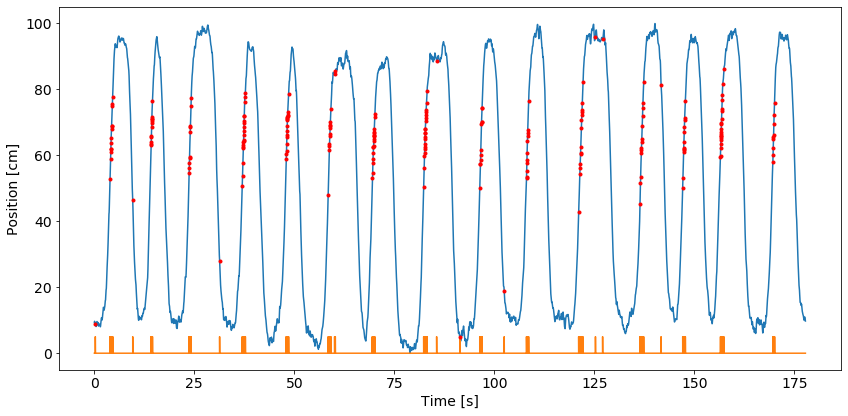

In [4]:
## Plot the rat's position at the time of spikes as red dots overlaid on position plot

ax1.plot(t[t_spk_idxs], x[t_spk_idxs], color='r', marker='.', linestyle='None')
fig1

From the above figure, it is clear that the preponderance of the spiking is occurring whenever the rat is running up the track, in the direction where `x` is increasing, at values of `x` ranging from about 50 cm to about 80 cm. We do not see the same spiking activity in this region when the rat is running back down the track, in the direction where `x` is decreasing. A few spikes occur at other locations, but these appear sparse compared to the place-specific firing in this region.

Another way to visualize this place field structure is to construct an **occupancy normalized histogram** of the spiking activity. To do so, we define a set of position bins spanning the full 100 cm track, count the number of spikes that occur in each location bin, and divide by the occupancy (the total amount of time spent at each location bin). Occupancy normalization is important; if we don't do this, then differences in the way the stimulus is presented can bias the characterization of the stimulus response relation. For example, if the rat spent much more time in the 50–80 cm region, our null hypothesis should expect more firing in that region even if the firing does not depend on place at all, so we need to normalize for this.  Based on our previous visualization, we don't see particularly strong outliers for occupancy for this data, but it is important to keep in mind how the statistics of a stimulus signal might influence the statistics of an output signal.

Let's now compute and plot the occupancy normalized spike histogram:

Text(0.5, 1.0, 'Occupancy Normalized Spike Histogram')

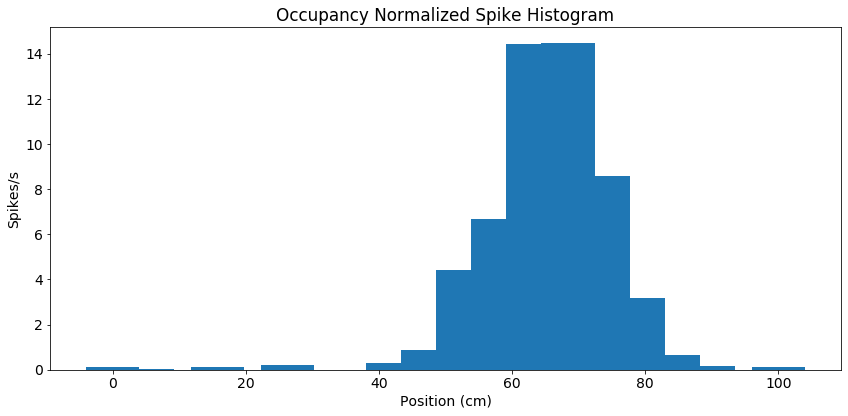

In [5]:
## Compute and plot occupancy normalized spike histogram

# Define spatial bins.
bins = np.arange(0, 101, 5)
# Calculate occupancy for `bins` and convert to seconds based on sampling rate.
occupancy = np.histogram(x, bins)[0] * dt
# Get spike count histogram based on `bins`.
spk_count_hist = np.histogram(x[t_spk_idxs], bins)[0]      
# Calculate normalized `spk_count_hist` based on `occupancy`.
spk_count_hist_norm = spk_count_hist / occupancy
# Plot histogram as a bar plot.
fig2, ax2 = plt.subplots()
ax2.bar(np.linspace(0, 100, 20), spk_count_hist_norm, width=8)
ax2.set_xlabel('Position (cm)')
ax2.set_ylabel('Spikes/s')
ax2.set_title('Occupancy Normalized Spike Histogram')

In addition to position, we might also want to account for spiking as a function of direction. One option for visualizing this would be to
construct separate occupancy normalized histograms for movement in each direction. We'll do so later when constructing place field models.

<a id="data-analysis"></a>
## Data Analysis

<a id="fitting-a-point-process-model"> </a>
### Fitting a Point Process Model (Poisson GLM)

Any statistical model that describes data occurring at localized points in time, like spike times, is called a *temporal point process model*. In chapter 8, we constructed a statistical temporal point process model that described the probability distribution of waiting times between spikes for a neuron with no explicit driving stimulus. Here, we would similarly like to construct a statistical model, but in this case the model should characterize how the distribution of the data depends on the covariates of interest: the rat’s position and movement direction.

One approach we used to model the spiking data in chapter 8 was a Poisson model, in which we used a rate parameter, $\lambda$, to define the expected rate of spiking in any time interval. We then computed the value of $\lambda$ that maximized the likelihood of observing the recorded spiking activity. For the data of interest here, we extend this concept by defining a $\lambda$ that varies as a function of some set of covariates - in this case, the rat's position and movement direction. In other words, we will fit a value for $\lambda$ for each unique combination of position and direction.

Let’s define some terms. Let $x(t)$ represent the rat’s position, $x$ at time $t$, and let $d(t)$ represent the movement direction at time $t$; we set $d(t)$ = 0 when $x(t)$ is decreasing or the rat is stopped, and $d(t)$ = 1 when $x(t)$ is increasing. Since these position and direction signals change as a function of time, so does the firing rate. We write

$$ \lambda(t) = g(x(t),  d(t)) $$

where $ \lambda(t)$ is the Poisson rate function, and $g$ is a function that we need to define the model. 

The key to the idea of using generalized linear models can be seen in this simple equation: we want to estimate the mean of a response variable (which in this case is the $\lambda$ parameter of the Poisson distribution) as a function ,$g$, of a linear combination of covariates, $x$ and $d$. That is, whatever function $g$ we choose to "wrap" our covariates, we can only add or subtract the different covariate terms. We could, for example, do $g(\sqrt(x) + d)$, but we could not do $g(x^{d})$.

Thus, there are three components to a GLM: 

1) The distribution chosen to model the response variable, which must come from the [exponential family of distributions](https://en.wikipedia.org/wiki/Exponential_family) (in this case, the Poisson distribution).

2) The linear combination of covariates you are using to predict the mean of your response variable (in this case, we could use, for example, $\sqrt(x) + d$).

3) The **mean function**: the function that wraps the linear combination of covariates to predict the mean of the response variable (in this case, $g$). 

The mean function is how the GLM can actually create a nonlinear scaling of the mean of the response variable as a function of the covariates: for example, we could use $e^{x + d}$ as our $g$. The inverse of the mean function is known as the **link function**, and is used to convert the mean function to a linear scale. For the example of the mean function $e^{x + d}$, we would use the $\log$ link function, to convert this to simply $x + d$.

So, what function should we use for $g$? We want something that captures the relation between the covariates and the spiking, and is easy to interpret. The process of finding a model or set of models that are most consistent with the data is called model identification or model selection. Typically, this is an iterative process where we propose a class of models, find the particular model in that class that best fits the data, assess the quality of that model, and decide whether to refine the model further or to draw conclusions from the model fit. In practice, it is a good idea to begin with descriptive statistics and visualizations of the relation between the covariates and spiking data to select a class of point process models. For the spike train data of interest here, our visualizations suggest a model where the dependence of spiking on position has a mound shape (as in the occupancy normalized histogram) and which incorporates direction.

We'll start with an overly simple model for pedagogical purposes. The following is a very basic model inspired by simple linear regression, and this initial model only uses the position covariate, and does not take into account direction:

$$ \lambda(t) = \beta_0 + \beta_1 x(t) $$

In this case, our mean function is already in a linear scale, so the link function we use will not transform the mean function in any way: this is known as the **identity** link function.

The idea of the regression here is to express the response variable $\lambda$ in terms of parameters that act on the covariates. Here, $\beta_0$ and $\beta_1$ are unknown parameters used to characterize a linear dependence between the response variable $\lambda(t)$ and covariate $x(t)$. $\beta_0$ represents the expected firing rate at $x(t) = 0$, and $\beta_1$ represents the change in firing rate for each unit of increase in position. 

The goal of using a GLM is to find the ideal values for these unknown $\beta$ parameters in order to find the value for $\lambda$ that best fits the data.

We choose to use a Poisson regression model here since we know that a Poisson distribution is a decent distribution for modeling spike counts, which can only take on non-negative integer values. If we let $N(t)$ be the number of spikes that are observed in the interval $(t, t +  \Delta t)$, then under the Poisson regression model, $N(t)$ has a Poisson distribution with a mean parameter equal to the response variable $\lambda(t)$ integrated over the interval $(t, t +\Delta t)$.

How do we fit the Poisson regression model? We will use the package `statsmodels`, and we will construct a GLM using:

`GLM(y, x_1, family=distribution(link)).`

The first input, `y`, is the response variable. In this case, it is a vector of the spike counts at each time step. The second input, `x_1`, is the design matrix. It is a matrix of the covariates on which spiking depends at each time step. `y` and `x_1` must therefore have the same number of rows (time steps in this case, or more generally, observations). The number of columns of `x_1` is equal to the number of covariates in our model. Since our model is given by $\lambda(t) = \beta_0 + \beta_1x(t)$, we will prepend a column of ones to the design matrix `x`, so that we can fit the intercept $\beta_0$ to our data. The third input indicates the distribution of the spike count data in `y` and the link function to use to relate the mean of this distribution to the covariates. In this case, it is the Poisson distribution with the identity link function.

Let’s now fit `model1` to the observed location and spiking data:

C:\Users\Jai\Anaconda3\envs\base_clone\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:278: DomainWarning: The identity link function does not respect the domain of the Poisson family.
  DomainWarning)


model1: B_0 = -0.000. B_1 = 0.000


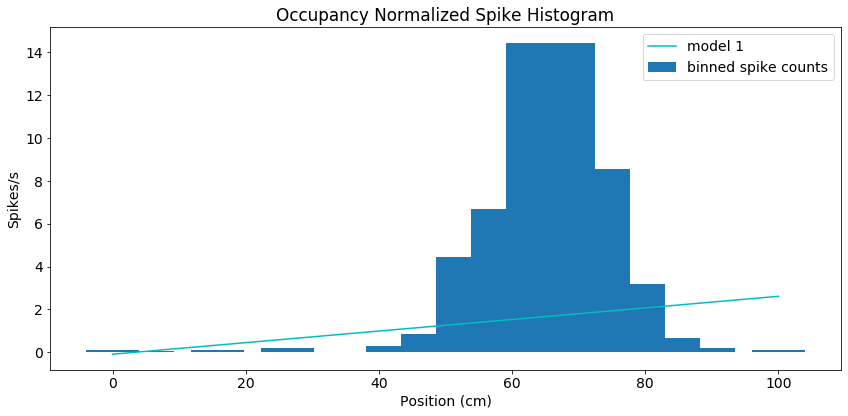

In [6]:
## Fit GLM to spike counts based on position using Poisson distribution and identity link function

# Prepend a column of ones to the position data to create a data matrix with shape=(n,2).
x_model1 = np.array([np.ones_like(x), x]).T
# Specify the response variable distribution and link function.
h_model1 = sm_glm_fams.Poisson(link=sm_glm_fams.links.identity())
# Create and fit the model.
model1 = sm.GLM(t_where_spks, x_model1, h_model1)
model1_results = model1.fit()
# Print fitted model params.
b_model1 = model1_results.params
print(f'model1: B_0 = {b_model1[0]:.3f}. B_1 = {b_model1[1]:.3f}')
# Plot the model on top of occupancy-normalized spike count hist.
model1_vals = (b_model1[0] + b_model1[1] * bins) * (1/dt)
ax2.plot(bins, model1_vals, 'c')
ax2.legend(['model 1', 'binned spike counts'])
fig2

You may notice that Python output a warning that this model — particularly the choice of the link function as the identity function — may be inappropriate. Let’s attempt to interpret the resulting parameter estimates, and we'll see why this warning was thrown.

If we believed this model was accurate, we could interpret the first parameter value ($\beta_0$) as indicating that the expected firing rate at position x = 0 is negative (-9.65 e-05), and that as the rat moves in the positive direction, the firing rate (the second parameter value, $\beta_1$) increases by 2.71 e-05 spikes per ms for every centimeter the rat moves. This result should immediately raise some red flags. The fact that the firing rate can be negative indicates that the model becomes uninterpretable for observed values of x: this suggests one major problem with the model and motivates changes to the model link function. We also see that the model misses much of the structure of the data; for example, the fact that the empirical spike rate does not change linearly with position and begins to decrease as the rat’s position increases beyond x = 70 is not captured by the model: this suggests a second issue with this model - the form of the relation between position and firing rate is wrong.

<a id="refining-the-model"> </a>
### Refining the model

We concluded that our initial proposal, `model1`, does not fit the data well, so let’s refine the model to account for the identified issues. First, let’s choose a link function that is more appropriate for point process modeling. We would like a link function that ensures the rate function is non-negative and that is easy to fit. The theory of generalized linear modeling suggests one function in particular: the log link. The log link will set the log of the firing rate to be a linear function of the covariates. If we maintain position as the sole covariate, this leads to a model of the form:

$$ \log \lambda(t) = \beta_0 + \beta_1 x(t) $$
or equivalently
$$ \lambda = e^{\beta_0+\beta_1x(t)} $$

This link function is called the canonical link for Poisson data. It has a number of appealing properties, one of which is that it ensures that the rate function is positive, as we desired. The choice of a log link also ensures that the likelihood of the data is concave with respect to the model parameters. This means that the likelihood only has one local maximum value, which is the maximum likelihood (ML) estimate. It can also be shown that in many cases, the parameter estimators will be asymptotically normal, which will allow us to construct confidence intervals and make significance statements about them.

To fit this new model, `model2`, we can use the same code as before but replace the identity link with the log link:

B_0 = -7.439. B_1 = 0.013


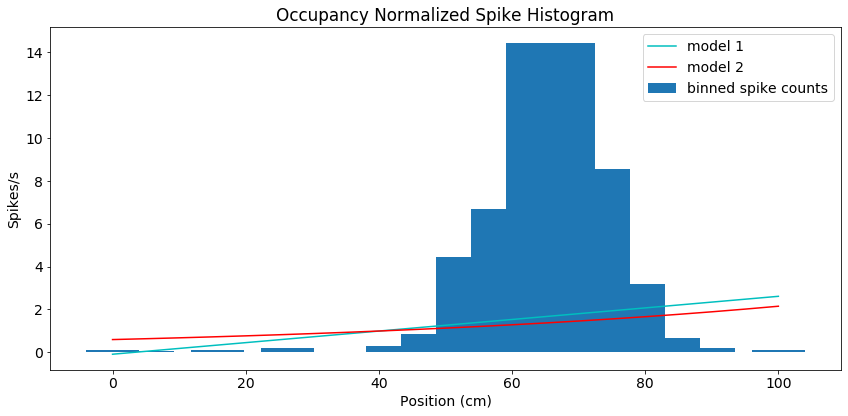

In [7]:
## Fit GLM to spike counts based on position using Poisson distribution and log link function

# Set design matrix.
x_model2 = x_model1
# Create and fit new model.
h_model2 = sm_glm_fams.Poisson(link=sm_glm_fams.links.log())
model2 = sm.GLM(t_where_spks, x_model2, h_model2)
model2_results = model2.fit()
# Print fitted model params.
b_model2 = model2_results.params
print(f'B_0 = {b_model2[0]:.3f}. B_1 = {b_model2[1]:.3f}')
# Plot the model on top of occupancy-normalized spike count hist.
model2_vals = np.exp(b_model2[0] + b_model2[1] * bins) * (1 / dt)
ax2.plot(bins, model2_vals, 'r')
ax2.legend(['model 1', 'model 2', 'binned spike counts'])
fig2

Let’s examine the model fit more closely. When x = 0, the firing rate under model 2 is

$$\begin{align}\lambda(t) &= e^{\beta_0 + \beta_1 * 0}\\
&= e^{\beta_0}\\
&= 0.0006\text{ spikes/ms}\\
&= 0.6 \text{ spikes/s,}\end{align}$$

If the rat moves from position x = 0 to x = 1, the firing rate becomes

$$\begin{align}\lambda(t) &= e^{\beta_0 + \beta_1 * 1} \\
&= e^{\beta_0 + \beta_1}\\
&= e^{\beta_0} * e^{\beta_1}\\
&= 1.013 \exp(\beta_0),\end{align}$$

In words, this means that a 1 cm increase in position increases the firing rate 1.3%. Because of the log link, position now has a multiplicative rather than an additive effect on the firing rate. That is, there is now a multiplicative increase of the firing rate at 1.3% per cm increase, rather than a fixed linear addition to the firing rate per cm increase.

With `model2` we’ve solved one problem: the spike rate is no longer negative anywhere. However, the model fit still does not agree with the structure seen in the occupancy normalized histogram. We have improved the link function, but using only the position itself as a covariate leads to a spike rate that is just an exponential function of the rat’s position, and this clearly does not fit the data.

There are many variables we might think to add to this model, but what variables could we add to better capture the dependence between firing rate and position, in particular? One thought might be to include nonlinear terms, such as the square of the position value. This gives us a third candidate model:

<p title="Model 3">$$\lambda(t) = e^{\beta_0+\beta_1x(t)+\beta_2x(t)^2}.$$</p>

Compared to model 2, we’ve now included an additional $x(t)^2$ term and unknown coefficient $\beta_2$.

Let's now create, fit, and plot this new model, `model3`:

B_0 = -26.279. B_1 = 0.690, B_2 = -0.005


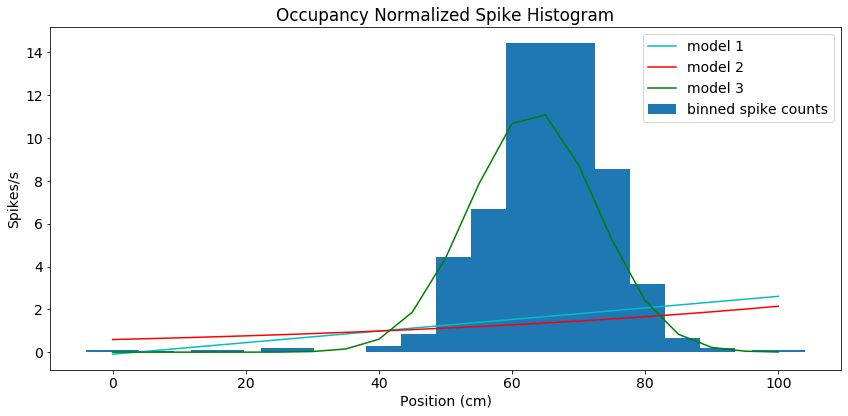

In [8]:
## Fit GLM to spike counts based on position and squared position using Poisson distribution and log link function

# Add column for squared position.
x_squared = np.reshape((x ** 2), (len(x), 1))
x_model3 = np.hstack([x_model2, x_squared])
# Create and fit new model.
h_model3 = sm_glm_fams.Poisson(link=sm_glm_fams.links.log())
model3 = sm.GLM(t_where_spks, x_model3, h_model3)
model3_results = model3.fit()
# Print fitted model params.
b_model3 = model3_results.params
print(f'B_0 = {b_model3[0]:.3f}. B_1 = {b_model3[1]:.3f}, B_2 = {b_model3[2]:.3f}')
# Plot the model on top of occupancy-normalized spike count hist.
model3_vals = np.exp(b_model3[0] + (b_model3[1] * bins) + (b_model3[2] * bins ** 2)) * (1 / dt)
ax2.plot(bins, model3_vals, 'g')
ax2.legend(['model 1', 'model 2', 'model 3', 'binned spike counts'])
fig2

Let’s now interpret the parameter estimates for `model3`. The estimate of the first parameter is $\beta_0 = −26.3$. This means that when the rat is at position $x = 0$, the firing rate is $\lambda(t) = e^{\beta_0} = e^{−26.3} ≈ 0$. There is almost no chance of observing a spike when the rat is at this location. What happens as the rat moves in the positive direction? This is determined by both $\beta_1 = 0.69$ and $\beta_2 = −0.0055$. For every unit increase in position, the firing rate is multiplied by $e^{\beta_1} = 1.99$, but at the same time, for every unit increase in the squared position, the firing rate is multiplied by $e^{\beta_2} = 0.99$.

We see from the figure above that `model3` aligns much more closely with the occupancy normalized histogram. The firing rate is small at the beginning of the track, increases to a maximum firing rate near 10 Hz about 60 cm along the track, and then decreases as the position increases further. The firing rate model as a function of position looks like the bell-shaped or mound-shaped density that we often associate with the Gaussian (or normal) distribution. The fact that the firing rate is the exponential of a quadratic function of position means that we can rewrite the model in a form that more closely resembles the Gaussian function:

$$ \lambda(t) = \alpha e^{\left(-\frac{(x - \mu)^2}{ 2\sigma^2}\right)},$$

where $\mu = −\beta_1/(2\beta_2)$ represents the position of the center of the place field, $\sigma = \sqrt{−1 / (2\beta_2)}$ represents the distance of one standard deviation of the place field, and $\alpha = e^{\beta_0−\beta_1^2/(4\beta_2)}$ is the maximum firing rate at the place field center.

In this example, we can use the estimated GLM coefficients to estimate these new model parameters related to the center, size, and maximum firing rate of the place field. The `fit` method has given us the maximum likelihood estimates for $\beta_0$, $\beta_1$, and $\beta_2$. An important result from statistical theory is that the maximum likelihood estimate of any function of model parameters is just that same function of the maximum likelihood estimates of the parameters. This is known as invariance or equivariance. So $\hat{\mu} = −\hat\beta_1/(2\hat{\beta_2})$ is the maximum likelihood estimate of $\mu$, and similarly, $\hat{\sigma}$ is the mle of $\sigma$ and $\hat{\alpha}$ is the mle of $\alpha$.

Let’s now use these expressions to compute the maximum likelihood estimates of $\mu$, $\sigma$, and $\alpha$:

In [9]:
## Compute mle of Gaussian parameters from mle of Poisson regression parameters

mu_model3 = -b_model3[1] / (2 * b_model3[2])  # place field center
sigma_model3 = np.sqrt(-1 / ( 2 * b_model3[2]))  # place field size
alpha_model3 = np.exp(b_model3[0] - (b_model3[1] ** 2) / (4 * b_model3[2]))  # max firing rate
print(f'mu: {mu_model3:.3f}')
print(f'sigma: {sigma_model3:.3f}')
print(f'alpha: {alpha_model3:.3f}')

mu: 63.163
sigma: 9.567
alpha: 0.011


We see from $\mu$ that that the estimated place field center is about 63.2 cm down the track. We see from $\sigma$ that the firing rate decreases about 40% (the decrease in peak value one standard deviation away from the mean of a normal distribution's pdf) when the rat is about 9.6 cm from the place field center, and decreases about 85% (the decrease in peak value two standard deviations away from the mean of a normal distribution's pdf) when the rat is about 19.2 cm from the place field center. We see from $\alpha$ that the cell spikes at a rate of about 11 spikes/s at the place field center.

<a id="comparing-and-evaluating-models"> </a>
### Comparing and Evaluating Models

We have fit a number of models for the receptive field of this neuron and compared these models through visual inspection. Ideally, we’d like to go beyond qualitative comparisons and consider quantitative tools to help us evaluate and compare different models. For statistical models, we often use the term *goodness-of-fit* to describe how well a model captures structure in the observed data, and how well the model predicts future data. There is not a single procedure for measuring goodness-of-fit; instead there are many tools that, taken together, can provide a broad perspective on the strengths and weaknesses of a set of models. We explore some approaches for comparing the relative goodness-of-fit between two models and then methods to assess the overall goodness-of-fit of a single model.

<a id="comparing-AIC-values"> </a>
#### Method 1: Comparing AIC Values.

Let’s say we want to compare the quality of the fit to the data of `model2` and `model3`. What measure could we use to compare these models? A natural thought is to use the likelihood. We have already used the likelihood to select the parameter values for each of these models; we selected the parameters that maximized the likelihood of the data. We can think of selecting the model parameters as selecting among a set of models with the same model form but different parameter values. In that case, the likelihood was the measure we used to make the selection.

However, there is a major issue with using the likelihood alone to compare goodness-of-fit between different classes of models. It turns out that as we add parameters to the model and make the model more complex, we tend to increase the likelihood of the data, whether or not those additional terms accurately describe the processes that generate the data. If we were to select models that maximize the likelihood of the data without regard for model size, we would tend to increase the number of parameters in our models, and so we would get very large models that fit the observed data well but do not predict or describe future data well. This is known as the *overfitting problem*. In order to avoid overfitting, we are compelled to balance the ability to fit complicated datasets with the desire to use simple models with small numbers of parameters. This trade-off in modeling is sometimes referred to as the goal of **parsimony**, and a **parsimonious model** is one that fits that data well with as few parameters as possible.

One common approach for preventing overfitting is **cross-validation**. There are multiple types of cross-validation, but generally they all share these five common steps: 1) select a **training set** - a subsample of the data (e.g. 60% of the observations) - and fit the model on this subsample; 2) select a **validation set** - a separate, unique subsample of the data (e.g. 20% of the observations) - and evaluate how well the trained model fits this subsample; 3) depending on the model's performance on the validation set, adjust hyperparameters as desired and repeate steps 1 & 2; 4) test the final model on a **test set** - a final separate, unique subsample of the data (e.g. the final 20% remaining observations) - and evaluate how well the final model fits this subsample; 5) repeating these four steps for many different models, and choose the model that performs the best on the test set.

One challenge with cross-validation is that it can be computationally expensive. Here, instead of fitting a large number of models, we take another approach, which gives results equivalent to cross-validation when the dataset is large. Namely, we use penalized likelihood measures to compare model types. These measures make explicit the trade-off between fitting the data well (by increasing the likelihood) and using a small number of parameters (by penalizing large models).

Let’s consider one such measure, *Akaike’s information criterion* (AIC). It is defined as

$$\text{AIC} = 2k − 2 \log L(\theta_{ML})$$

where $L(\theta_{ML})$ is the likelihood of the data for the selected maximum likelihood parameter estimate $
\theta_{ML}$, and $k$ is the number of parameters in the model. 

We think of the $2k$ in the expression as a penalty for models with large numbers of parameters. When comparing models, we compute the AIC for each model separately, and then compare the AIC values: the model with the lower AIC is estimated to have a smaller amount of information lost in modeling the data, and is thus deemed the better model.

Let's now compare the AIC values between `model2` and `model3`:

In [10]:
## Compare AIC values between `model2` and `model3`

# Compute likelihood value of of best-fit model.
log_likelihood_model2 = model2.loglike(b_model2)
log_likelihood_model3 = model3.loglike(b_model3)
# Compute and compare AICs from likelihoods.
aic_model2 = (2 * 2) - (2 * log_likelihood_model2)
aic_model3 = (2 * 3) - (2 * log_likelihood_model3)
print(f'AIC of model2: {aic_model2:.3f} \nAIC of model3: {aic_model3:.3f}')

AIC of model2: 3344.791 
AIC of model3: 2708.776


We see that the AIC of `model3` is about 636 less than that of model 2, suggesting that model 3 is superior. How should we interpret the value of the difference? The answer depends on the probability model we are using, and generally we are just interested in which model has the lowest AIC without worrying about the magnitude of the difference. However, one rough way of thinking about this value is in terms of the penalty. The fact that model 3 has an AIC of about 636 less than the AIC of model 2 suggests that model 3 would still be preferable to model 2 even if model 3 had 636/2 = 318 more parameters than it actually does.

It turns out that there is a simpler way to compute the difference in AICs between two GLMs. Whenever the `statsmodels` package (and most other computational software packages) computes the maximum likelihood solution for a GLM, it also computes the model deviance. The model deviance is a measure of lack of fit between the model and data, which is defined by

$$ \text{Deviance }= C − 2\log L(\theta_{ML}) $$

where $C$ is a constant: -2 * the log likelihood of a saturated model that has as many parameters as points in the data. The two values for $C$ of two different models of the same family fit to the same data will be equal, so we can cancel them out when when comparing the fit of two models, and we can get

$$ \Delta \text{AIC}=\text{AIC}_1−\text{AIC}_2 = (2k_1 + \text{Dev}_1) − (2k_2 + \text{Dev}_2) $$

Let's now compute the $\Delta$AIC between `model2` and `model3`:

In [11]:
## Compute the difference in AIC values of the two models using the models' deviance

dev_model2 = model2_results.deviance
dev_model3 = model3_results.deviance
diff_aic_m23 = ((2 * 2) + dev_model2) - ((2 * 3) + dev_model3)

# The AIC values are also stored as an attribute of a fitted `GLMResults` class:
diff_aic_m23_2 = model2_results.aic - model3_results.aic
assert (np.round(diff_aic_m23, decimals=5) == np.round(diff_aic_m23_2, decimals=5))

print(f'Diff AIC value is: {diff_aic_m23:.3f}')

Diff AIC value is: 636.015


<a id="maximum-likelihood-ratio-test-for-nested-models"> </a>
#### Method 2: Maximum Likelihood Ratio Test for Nested Models. 

The AIC provides a method for identifying parsimonious models and comparing between models but does not, on its own, indicate whether a particular model provides a statistically significant improvement in its description of a dataset. In order to assess whether a model provides a significant improvement over another, we can use hypothesis tests based on the model likelihoods.

In particular, there is a general class of hypothesis tests called *maximum likelihood ratio tests* (MLRTs) that often provide the most statistically powerful comparison between models. In general, it can be challenging to compute the test statistic and its sampling distribution for MLRTs. However, it becomes easy to perform this test in cases where we are comparing two **nested GLMs**; that is, when one of the models can be made equivalent to the other by setting some parameters to specific values. For example, it is possible to make `model3` equivalent to `model2` by setting $\beta_2 = 0$. We say that `model2` is _nested_ in `model3`. It can be shown that when we compare two nested Poisson regression GLMs, the MLRT will asymptotically be a simple chi-square ($\chi^2$) test.

Let’s specify the components of this hypothesis test. Assume that the nested model has $n_1$ parameters $\{\beta_1, \cdots, \beta_{n_2} \}$, and that the larger model has $n_2$ parameters, $\{\tilde{\beta_1}, \cdots, \tilde{\beta_{n_2}} \}$. The null hypothesis for this test is $H_0 : \tilde{\beta_{n_1 + 1}} = \cdots = \tilde{\beta_{n_2}}= 0$; that is, that all the additional parameters not contained in the nested model are equal to zero. The alternative hypothesis is that at least one of these additional parameters is different from zero. The test statistic for this MLRT is equivalent to the difference in the deviances between the nested model (here, $\text{Dev}_1$) and the larger model (here, $\text{Dev}_2$),

$$\Lambda = \text{Dev}_1 - \text{Dev}_2$$

Under the null hypothesis, this statistic should asymptotically have a chi-square distribution with $n_2 − n_1$ degrees of freedom.

Let’s compute the p-value for a MLRT comparing models 2 and 3 using the chi-square distribution:

In [12]:
## Compare MLRT for `model2` and `model3`.

diff_dev_m23 = dev_model2 - dev_model3
df_m23 = 3 - 2  # degrees of freedom
p_mlrt_m23 = 1 - stats.chi2.cdf(diff_dev_m23, df_m23)
print(f'The probability that all the additional (non-nested) parameters in model3 are equal to 0 is {p_mlrt_m23:.3f}')

The probability that all the additional (non-nested) parameters in model3 are equal to 0 is 0.000


From this MLRT, we see that there is significant evidence to suggest that it is not the case that the additional parameters in `model3` do not improve the fit over `model2`.

<a id="confidence-intervals-for-individual-model-parameters"> </a>

#### Method 3: Confidence Intervals for Individual Model Parameters. 

If we want to test directly for whether a single parameter contributes significantly to the model, we can examine its interval estimate. If the true value of a parameter is zero, then the covariate corresponding to that parameter does not contribute to the prediction of the data in the model. Therefore, if the confidence interval for a parameter does not contain zero, then we can say we do not have sufficient evidence at that confidence level to state that the covariate for that parameter does not significantly contribute to the fit of the model.

`Statsmodels`' GLM fitting procedure not only computes the maximum likelihood estimator for each model parameter but also computes the **Fisher information**, a quantity related to the curvature of the likelihood function, which can be used to compute confidence intervals about any individual parameters or any combination of parameters. The Fisher information is a way of measuring the amount of information that an observable random variable $X$ carries about the parameters upon which it depends.

We do not discuss the Fisher information in detail here, but the basic idea is intuitive: if the likelihood function is very flat at its maximum, then a slight change in the parameter values will only have a slight change in the corresponding likelihood value, while if the likelihood is very peaked at its maximum, then a slight change in the parameter values will have a large change in the corresponding likelihood value. I.e. for a flat likelihood function, there is a potentially large range of parameter values that makes the data likely, while for a peaked likelihood function, a much narrower range of parameter values makes the data likely. $X$ carries more info about its parameters when the likelihood function is peaked, so the Fisher information is greater for a peaked rather than a flat likelihood function.

The variance of a parameter estimate is approximately equal to the inverse of the Fisher information matrix, evaluated at the estimates. The standard error is the square root of this variance. The standard error of each parameter estimate will allow us to compute an interval estimate. Since maximum likelihood estimators have approximately normal distributions with enough data, an approximate 95% confidence interval for any parameter $\beta_i$ would be $\beta_i \pm 1.96\hat{\sigma_{\beta_i}}$ , where $\beta_i$ is the parameter estimate and $\hat{\sigma_{\beta_i}}$ is the estimated standard error.

Let’s now compute confidence intervals for the parameters of our models from the estimated parameters' standard errors:

In [13]:
## Compute confidence intervals for parameters of best-fit models

# Compute CI from estimated parameters' standard errors
ci_params_model2 = np.round(np.array([b_model2 - (1.96 * model2_results.bse), 
                                      b_model2 + (1.96 * model2_results.bse)]),
                            decimals=5).T
ci_params_model3 = np.round(np.array([b_model3 - (1.96 * model3_results.bse), 
                                      b_model3 + (1.96 * model3_results.bse)]), 
                            decimals=5).T
print(f'Confidence intervals for model2 params are: \n{ci_params_model2}')
print(f'Confidence intervals for model3 params are: \n{ci_params_model3}')

Confidence intervals for model2 params are: 
[[-7.72854 -7.14924]
 [ 0.009    0.01689]]
Confidence intervals for model3 params are: 
[[-2.988078e+01 -2.267734e+01]
 [ 5.800600e-01  8.001700e-01]
 [-6.290000e-03 -4.630000e-03]]


Here we see that at the 95% confidence level, none of the confidence intervals for the parameters of `model2` nor `model3` contain zero, which suggests that all the covariates we used in these models contribute to their predictive power.

Now we should try to interpret these confidence intervals in the context of the neuron, from which this data comes, potentially being a place cell. 

To do so, for `model2` we can simply exponentiate these confidence intervals, and for `model3` we can go back to our previous equation where we rewrote the lambda parameter mean function in gaussian-form:

In [14]:
## Transform the confidence intervals of the model parameters to gain better interpretability

# For model2.
print(f'Interpretable confidence inverals for model2 params:\n {np.round(np.exp(ci_params_model2), decimals=5)}')
# For model3.
ci_mu_model3 = np.round(-ci_params_model3[1, :] / (2 * ci_params_model3[2, :]), decimals=5)
ci_sigma_model3 = np.round(np.sqrt(-1 / (2 * ci_params_model3[2, :])), decimals=5)
ci_alpha_model3 = np.round(np.exp(ci_params_model3[0, :] - (ci_params_model3[1, :] ** 2) 
                                  / (4 * ci_params_model3[2, :])), decimals=5)
print('\nInterpretable confidence intervals for gaussian-form model3 params:'
      f'\nmu: {ci_mu_model3} \nsigma: {ci_sigma_model3} \nalpha: {ci_alpha_model3:}')

Interpretable confidence inverals for model2 params:
 [[4.40000e-04 7.90000e-04]
 [1.00904e+00 1.01703e+00]]

Interpretable confidence intervals for gaussian-form model3 params:
mu: [46.1097  86.41145] 
sigma: [ 8.91579 10.39189] 
alpha: [     0.      146471.15688]


The `model2` parameter confidence intervals tell us that we are 95% certain that at position x=0, the firing rate is between 0.44 and 0.79 spikes/second (the $\beta_0$ intercept term), and that the firing rate increases by a factor of between 1.009 and 1.017 per cm increase in position along the track.

The gaussian-form `model3` parameter confidence intervals tell us that we are 95% certain that the center of the place field ($\mu$) is between 45.79 and 86.84 cm on the track, the distance of one standard deviation from the center of the place field ($\sigma$) is between 8.90 and 10.40 cm, and the peak firing rate at the center of the place field is between 0 and 206497000 spikes/s ($\alpha$). The confidence interval values for $\mu$ and $\sigma$ seem reasonable. The confidence interval values for $\alpha$ don't tell us much: because $\alpha$ is calculated from all three parameters in the mean function, its confidence interval has a much larger relative range than that for $\mu$ or $\sigma$.

We can also ask how significant are the model parameters? To answer this, we can conduct a hypothesis test for whether the parameters are different from zero. This test, based on the maximum likelihood estimate of a model parameter and its standard error, is called a **Wald test**.

Let's now look at the results of the Wald test run on all parameters for `model2` and `model3`:

In [15]:
## Get Wald test results for parameters for `model2` and `model3`

# For model2.
print(f'Model2 Wald test results: \n{model2_results.pvalues}')
# For model3.
print(f'\nModel3 Wald test results: \n{model3_results.pvalues}')

Model2 Wald test results: 
[0.00000000e+00 1.23834956e-10]

Model3 Wald test results: 
[2.16783459e-46 1.02271626e-34 4.11708043e-38]


As expected from our confidence intervals, the p-values returned from the Wald test for all the parameters in `model2` and `model3` are virtually 0.

<a id="ks-test-for-model-goodness-of-fit"> </a>
#### Method 4: KS Test for Model Goodness-of-Fit. 

The goodness-of-fit methods we have developed so far are useful for comparing models and for determining whether individual variables contribute significantly to a model. However, these methods do not tell us whether the model captures the structure of the spiking data well overall. There are a number of methods to evaluate the overall goodness-of-fit between a model and data, but here we focus on an approach specific to point process (spike) data.

In many statistical analyses, we assume that the data is independent and identically distributed; that is, that no one datapoint exerts any influence over the rest of the data, and that all the data comes from the same probability model. A common goodness-of-fit method is then to compare the empirical distribution of the data to that single probability model. However, for most spike trains, the data is neither independent nor identically distributed. For example, biological constraints and phenomena such as the refractory period of a cell and spike bursting violate the independent assumption, and phenomena such as changes in spiking rate due to other covariates violate the identically distributed assumption. 

Here we focus on correcting violations of the identically distributed assumption via the **time-rescaling theorem**, which provides a transformation of the data that is identically distributed if the rate model is correct.

---
#### Time-Rescaling Theorem:

Consider a collection of spike times $(S_1 , S_2 , \cdots, S_n)$ from a Poisson process with rate function $\lambda(t)$. Then let

$$ Z_i = \int_{S_{i-1}}^{S_i} \lambda(t) dt $$

for $i = 1, \cdots, n$. By the time-rescaling theorem, the rescaled variables, $Z_1 , Z_2 ,\cdots , Z_n,$ are independent and identically distributed random variables from the exponential distribution with rate parameter = 1.
<hr>

How do we use the time-rescaling theorem to analyze spike train data? If we have a collection of spike times, $S_1 , S_2 , \cdots , S_n$, and any Poisson rate model, say, from a fit GLM, then we can compute the time-rescaled parameter values, $Z_1,Z_2,\cdots ,Z_n$. We then perform any standard goodness-of-fit method to compare $Z_1,Z_2,\cdots ,Z_n$ to the exponential probability model with rate parameter = 1. If the Poisson rate model describes the data well, then the exponential model should describe the rescaled times well.

One goodness-of-fit technique we can use for the rescaled data is the **Kolmogorov-Smirnov (KS) plot**. Recall from chapter 8 that the KS plot compares the empirical cumulative distribution function (CDF) of the data to a model CDF. In that chapter, we compared the empirical CDF for observed ISIs against various model CDFs. In this case, we compare the empirical CDF of the rescaled parameter to a model exponential CDF.

Let’s now apply the time-rescaling theorem to evaluate `model3`:

Text(0.5, 1.0, 'KS Plot for time-rescaled parameter')

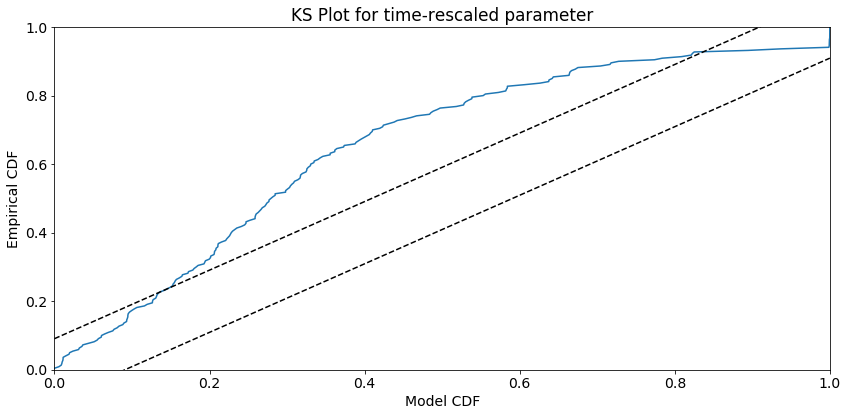

In [16]:
## Apply the time-rescaling theorem to the model to correct for violations of 
## the identically distributed assumption, and evaluate the goodness-of-fit of
## `model3` to the data via a KS plot of the cdf of the rescaled parameter vs. 
## the exponential distribution model that corresponds to our Poisson model

# Get rate parameter values for `model3` for each time step.
lambda_vals_model3 = np.exp(b_model3[0] + (b_model3[1] * x)
                            + (b_model3[2] * x ** 2))
# <s Rescale ISIs.
n_spks = len(ts)
# Prepend 0 to `t_spk_indxs` in order to account for the ISI from time=0 to 
# `t_spk_indxs[0]`
t_spk_idxs_0 = np.append(0, t_spk_idxs)
rescaled_param_vals_model3 = \
    [np.sum(lambda_vals_model3[t_spk_idxs_0[i_spk - 1] : t_spk_idxs_0[i_spk]])
     for i_spk in range(1, n_spks + 1)]
# /s>

# <s Compute empirical and model (exponential distribution) CDF of rescaled ISIs,
# and create KS plot with 95% confidence intervals.
ecdf_rescaled_param_model3 = \
    sm.distributions.empirical_distribution.ECDF(rescaled_param_vals_model3)
mcdf_rescaled_param_model3 = 1 - np.exp(-ecdf_rescaled_param_model3.x)  # rate parameter = 1
ks_95_ppf = stats.kstwo.ppf(0.95, n_spks)
fig3, ax3 = plt.subplots()
ax3.plot(mcdf_rescaled_param_model3, ecdf_rescaled_param_model3.y)  # ks plot
ax3.plot([0, 1], [(0 - ks_95_ppf), (1 - ks_95_ppf)], 'k--')  # ks lower bound
ax3.plot([0, 1], [(0 + ks_95_ppf), (1 + ks_95_ppf)], 'k--')  # ks upper bound
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])
ax3.set_xlabel('Model CDF')
ax3.set_ylabel('Empirical CDF')
ax3.set_title('KS Plot for time-rescaled parameter')  
# /s>

Here we see that the KS plot takes on values far outside of the 95% confidence bounds; therefore, we conclude that `model3` is not doing a good job of capturing the structure of the spiking data.

<a id="residual-analysis"> </a>
#### Method 5: Residual Analysis. 

Residuals represent the difference between the data and the model prediction at the level of individual data points. While quantities such as the deviance or KS plot are useful for getting an overall picture of how well the model fits the data as a whole, residual analysis is essential for understanding which components of a dataset are well or ill fit by the model. It is therefore one of the best tools for determining what is missing in a model.

There are many types of residuals that can be computed for point process data (including raw residuals, Pearson residuals, and deviance residuals). We will not go into detail about the advantages of each type of residual. Instead, let’s focus on one type of residual that is particularly useful for spiking data: the cumulative raw residual process. In continuous time, we would compute this residual process, $R(t)$, as

$$\begin{align}
R(t) &= \text{ total observed no. of spikes at time } t - \text{ total expected no. of spikes at time } t \\
     &= N(t) - \int_0^t\lambda(t)dt,
     \end{align}$$
     
where $N(t)$ is the counting process that gives the total number of spikes fired up to time $t$, and $\lambda(t)$ is the Poisson rate model at time $t$. The residual process $R(t)$ compares what’s observed (i.e., the spikes recorded in the data) to what the model produces. Since we are working in discrete time, at any time point $t_k$ we compute this as
$$ R(t_k) = \sum_{i=1}^k \Delta N_i  - \lambda(t_i)\Delta t,$$
where $\Delta N_i$ is the number of spikes that are observed in the discrete-time interval $t_i$.

For an ideal model, the residual process should have mean = zero and be uncorrelated with any covariates.

Let's plot the cumulative residual process for `model3`:

Text(0.5, 1.0, 'Cumulative Residual Process')

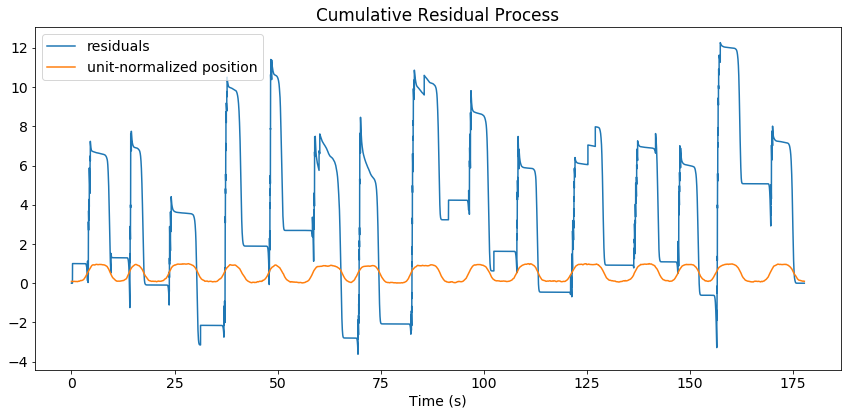

In [17]:
## Plot the cumulative residual process for `model3`, overlaid by the 
## unit-normalized position

resid_cum_model3 = np.cumsum(model3_results.resid_response)  # cumulative residuals
x_norm = x / np.max(x)  # normalized position
fig4, ax4 = plt.subplots()
ax4.plot(t, resid_cum_model3)
ax4.plot(t, x_norm)
ax4.set_xlabel('Time (s)')
ax4.legend(['residuals', 'unit-normalized position'], loc='upper left')
ax4.set_title('Cumulative Residual Process')

We see in the figure above that the cumulative residual process ends at zero, suggesting that the residuals sum to zero over all time steps. However, there is a pattern in the residual process, which suggests that there is still some structure in the data that is not captured by `model3`, which agrees with our KS plot of the time-rescaled parameter above. Specifically, the residual values seem to correlate with the rat's position: the residuals seem to increase whenever the rat in moving in the positive direction and decrease whenever the rat is moving in the negative direction. This analysis suggests that we should incorporate another covariate into our model: direction of movement.

<a id="refining-the-model-cont"> </a>
### 9.2.5 Refining the Model (Continued)

Our analysis of our models suggested that `model3` provided a significant improvement over `model2` in fitting the spiking data, however, analysis of `model3`'s time-rescaled parameter using the Poisson rate parameter, and `model3`'s cumulative residual process revealed that `model3` does not completely capture the structure of the spiking data: namely, `model3` does not account for the dependence of spiking on direction. 

So, let’s create a new model which incorporates a direction parameter. The simplest solution is to add onto our last model, giving us `model4`:

$$ \lambda(t) = e^{\beta_0 + \beta_1 x(t) + \beta_2 x(t)^2 + \beta_3 d} $$

Let's now fit this model and interpret the results:

In [18]:
## Fit `model4` and return estimates and useful statistics

# Create a covariate for direction from the diff of position
d = np.append(0, np.diff(x) > 0)  # 1 if increasing, else 0
# Create new data matrix incorporating `d`
x_model4 = np.concatenate((x_model3, d.reshape(len(x), 1)), axis=1)
h_model4 = sm_glm_fams.Poisson(link=sm_glm_fams.links.log())
model4 = sm.GLM(t_where_spks, x_model4, h_model4)
model4_results = model4.fit()
b_model4 = model4_results.params
model4_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               177761
Model:                            GLM   Df Residuals:                   177757
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1233.4
Date:                Fri, 20 Nov 2020   Deviance:                       2026.9
Time:                        19:01:43   Pearson chi2:                 1.30e+11
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -28.8699      1.869    -15.446      0.000     -32.533     -25.207
x1             0.6889      0.056     12.278      0.000       0.579       0.799
x2            -0.0055      0.000    -12.893      0.000      -0.006      -0.005
x3             3.2753      0.360      9.094      0.000       2.569       3.981
==============================================================================
"""

We are particularly interested in the parameter estimate for $\beta_3$. When the direction variable is equal to zero (when the rat is moving in the negative direction or standing still), this component does not affect the rate (the rate will be multipled by a factor of $e^{0} = 1$), while when the direction variable is equal to one (when the rat is moving in the positive direction), this component of the model modulates the rate by $e^{\beta_3}$. We see that the parameter estimate is 3.2753, and therefore that the firing rate is ~26 ($e^{3.2753}$) times higher when the animal is moving in the positive direction along the track.

We can also rewrite `model4` in gaussian-form as we did for `model3`. $\alpha$, $\mu$, and $\sigma$ will retain the same interpretations they held for `model3`, but now $\alpha$ will be multiplied by $e^{\beta_3}$ to account for direction.

Let's now compute the gaussian-form parameter estimates for `model4` and plot the model's values over two separate occupancy-normalized spike histograms (one for each direction of movement):

mu: 63.185
sigma: 9.577
alpha: 0.021689


Text(0.5, 1.0, 'Occupancy Normalized Spike Histogram')

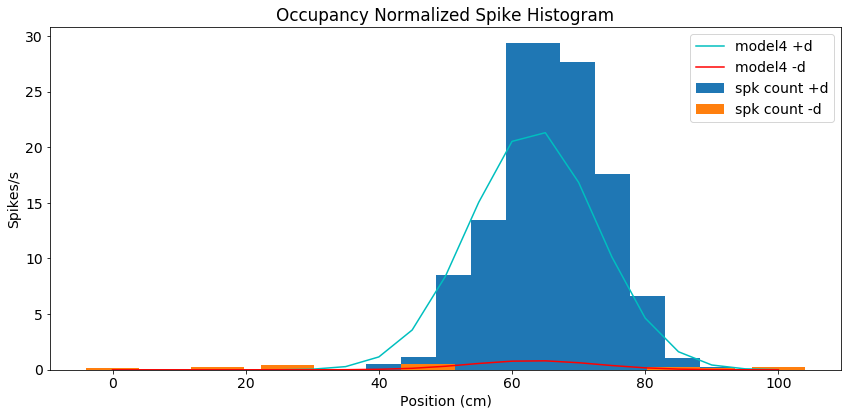

In [19]:
## Compute gaussian-form parameter estimates for `model4` and plot `model4` vals

# <s Compute gaussian form parameter etimates
mu_model4 = -b_model4[1] / (2 * b_model4[2])  # place field center
sigma_model4 = np.sqrt(-1 / ( 2 * b_model4[2]))  # place field size
alpha_model4 = np.exp(b_model4[0] - (b_model4[1] ** 2) 
                      / (4 * b_model4[2]) + b_model4[3])  # max firing rate

print(f'mu: {mu_model4:.5}')
print(f'sigma: {sigma_model4:.5}')
print(f'alpha: {alpha_model4:.5}')
# /s>

# <s Compute direction-specific occupancy normalized spike histograms and `model4` plot
# Define spatial bins.
bins = np.arange(0, 101, 5)
# Separate spike times in positive (up) and negative (down) directions
d_pos_idxs = np.where(d == 1)[0]
d_neg_idxs =  np.where(d == 0)[0]
t_spk_idxs_up = np.intersect1d(t_spk_idxs, d_pos_idxs, assume_unique=True)
t_spk_idxs_down = np.intersect1d(t_spk_idxs, d_neg_idxs, assume_unique=True)
# Get occupancy-normalized spike count histogram based on `bins`.
occupancy_up = np.histogram(x[d_pos_idxs], bins)[0] * dt
occupancy_down = np.histogram(x[d_neg_idxs], bins)[0] * dt
spk_count_hist_up = np.histogram(x[t_spk_idxs_up], bins)[0]
spk_count_hist_down = np.histogram(x[t_spk_idxs_down], bins)[0]
spk_count_hist_up_norm = spk_count_hist_up / occupancy_up
spk_count_hist_down_norm = spk_count_hist_down / occupancy_down
# Plot histograms and overlay `model4` vals
fig5, ax5 = plt.subplots()
hist_up = ax5.bar(np.linspace(0, 100, 20), spk_count_hist_up_norm, width=8)
hist_down = ax5.bar(np.linspace(0, 100, 20), spk_count_hist_down_norm, width=8)
model4_vals_up = np.exp(b_model4[0] + (b_model4[1] * bins) + (b_model4[2] * bins ** 2) + b_model4[3]) * (1 / dt)
model4_vals_down = np.exp(b_model4[0] + (b_model4[1] * bins) + (b_model4[2] * bins ** 2)) * (1 / dt)
model_4_vals_up_plot = ax5.plot(bins, model4_vals_up, 'c') 
model_4_vals_down_plot = ax5.plot(bins, model4_vals_down, 'r')
ax5.legend(['model4 +d', 'model4 -d', 'spk count +d', 'spk count -d'])
ax5.set_xlabel('Position (cm)')
ax5.set_ylabel('Spikes/s')
ax5.set_title('Occupancy Normalized Spike Histogram')

We see that our gaussian-form $\mu$ and $\sigma$ parameter estimates for `model4` are nearly identical to what they were for `model3`, and our $\alpha$ parameter is a bit higher, to take into the account that the maximum rate of firing is higher when we consider direction. The model values overlaid on the direction-specific occupancy normalized spike histogram suggest that our model does a decent job fitting the data now that it takes into account direction, but we should go back to our quantitative model evaluation tools to dig deeper.

<a id="comparing-and-evaluating-models-cont"> </a>
### 9.2.6 Comparing and Evaluating Models (Continued)

Now that we have a new model that attempts to capture the dependence of spiking on movement direction, let’s compare the resulting model fit to the previous model fits and evaluate the overall goodness-of-fit of this new model using the five same methods used above:

AIC difference of (model3 - model4) = 233.88, a decrease of 8.63%

P-value of MLRT of difference of deviances for (model3 - model4) = 0.0

Confidence intervals of model4 parameters are: 
[[-3.260797e+01 -2.513175e+01]
 [ 5.766700e-01  8.011000e-01]
 [-6.300000e-03 -4.610000e-03]
 [ 2.555010e+00  3.995660e+00]]

P-values for the Wald tests run on model4 parameters are: 
[7.99828412e-54 1.18778300e-34 4.90759442e-38 9.54220730e-20]


Text(0.5, 1.0, 'cumulative residual process for model4')

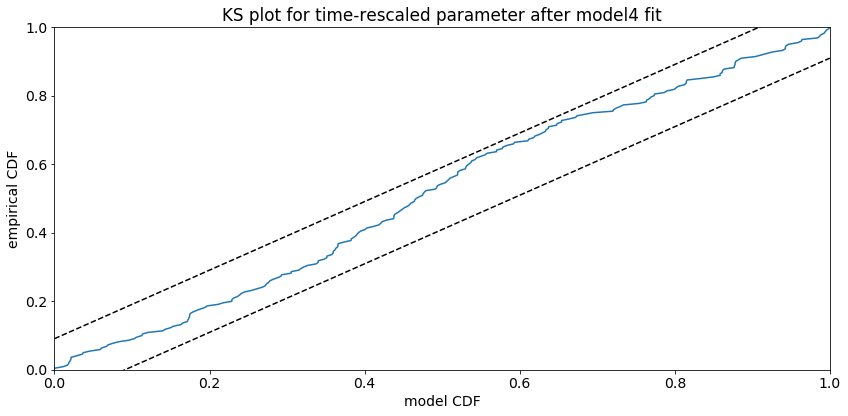

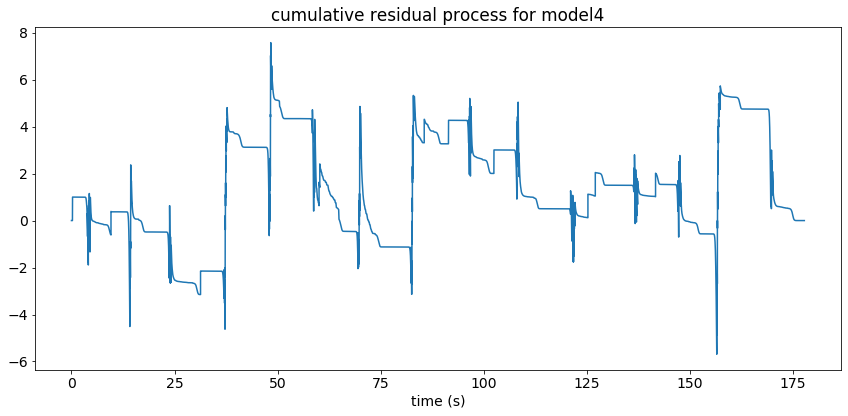

In [20]:
## Evaluate `model4` fit and compare to previous models

# AIC comparison between `model3` and `model4`.
aic_diff_m34 = model3_results.aic - model4_results.aic
aic_diff_percent_m34 = (1 - (model4_results.aic / model3_results.aic)) * 100
print(f'AIC difference of (model3 - model4) = {aic_diff_m34:.5}, a decrease of {aic_diff_percent_m34:.2f}%')

# MLRT of deviances between `model3` and `model4`.
dev_diff_m34 = model3_results.deviance - model4_results.deviance
df_m34 = 4 - 3
p_mlrt_m34 = 1 - stats.chi2.cdf(dev_diff_m34, df_m34)
print(f'\nP-value of MLRT of difference of deviances for (model3 - model4) = {p_mlrt_m34}')

# Test signifiance of `model4` params.
ci_params_model4 = np.round(np.array([b_model4 - (2 * model4_results.bse), 
                                      b_model4 + (2 * model4_results.bse)]), decimals=5).T
p_params_model4 = model4_results.pvalues
print(f'\nConfidence intervals of model4 parameters are: \n{ci_params_model4}')
print(f'\nP-values for the Wald tests run on model4 parameters are: \n{p_params_model4}')      

# Test that the time-rescaled variable comes from an exponential model with rate param = 1
lambda_vals_model4 = np.exp(b_model4[0] + (b_model4[1] * x)
                            + (b_model4[2] * x ** 2) + b_model4[3] * d)
rescaled_param_vals_model4 = \
    [np.sum(lambda_vals_model4[t_spk_idxs_0[i_spk - 1] : t_spk_idxs_0[i_spk]])
     for i_spk in range(1, n_spks + 1)]
ecdf_rescaled_param_model4 = \
    sm.distributions.empirical_distribution.ECDF(rescaled_param_vals_model4)
mcdf_rescaled_param_model4 = 1 - np.exp(-ecdf_rescaled_param_model4.x)  # rate parameter = 1
fig6, ax6 = plt.subplots()
ax6.plot(mcdf_rescaled_param_model4, ecdf_rescaled_param_model4.y)  # ks plot
ax6.plot([0, 1], [(0 - ks_95_ppf), (1 - ks_95_ppf)], 'k--')  # ks lower bound
ax6.plot([0, 1], [(0 + ks_95_ppf), (1 + ks_95_ppf)], 'k--')  # ks upper bound
ax6.set_xlim([0, 1])
ax6.set_ylim([0, 1])
ax6.set_xlabel('model CDF')
ax6.set_ylabel('empirical CDF')
ax6.set_title('KS plot for time-rescaled parameter after model4 fit')

# Plot the cumulative residual process
resid_cum_model4 = np.cumsum(model4_results.resid_response)  # cumulative residuals
fig7, ax7 = plt.subplots()
ax7.plot(t, resid_cum_model4)
ax7.set_xlabel('time (s)')
ax7.set_title('cumulative residual process for model4')

We find that the AIC value for `model4` is 233.88 (8.63%) less than for `model3`, suggesting a significant improvement in the fit of `model4` to the data over `model3`. 

From the MLRT of the difference of the deviances of (`model3` - `model4`), we find that the probability that `model4`'s $\beta_3$ parameter is not contributing to improving the fit is virtually 0.

We find that 0 is not contained in any of the 95% confidence intervals of the parameter estimates for `model4`, and that the p-values returned for the Wald tests for all parameter estimates of `model4` are virtually 0, which suggests that there is no evidence that any parameter in `model4` is not significantly contributing to the fit. 

When we perform our time-rescaling theorem analysis, we find that the KS plot of the model exponential distribution lies within 95% confidence bounds of the empirical cdf of the rescaled parameter values, suggesting that there is no evidence that `model4` is not a good fit of the spiking data.

And lastly, we find that the values in the cumulative residual process for `model4` are much smaller than they are for `model3`, and that though there still appears to be some pattern to the residuals, this pattern is not directly correlated with any of our covariates.

<a id="drawing-conclusions-from-the-model"> </a>
### 9.2.7 Drawing Conclusions from the Model Fitting

It is likely that we could refine `model4` further, perhaps by adding additional covariates or including different dependence structure on the covariates we are currently using. The process of model refinement is not about identifying a single correct model; instead, it is about building a model that sufficiently captures features of the data in which we are interested. For this analysis, let’s decide that based on our multiple model evaluation tools, `model4` is good enough: this model has allowed us to better understand the structure of the place cell that generated the spiking data.

This model has helped us identify important features of this neuron’s receptive field. It was clear from the initial visualizations that this neuron’s firing activity is position sensitive; it is more likely to fire when the animal is at certain positions than others. Our modeling analysis further showed that this position dependence could be well described by an exponentiated quadratic function of position, that is, a Gaussian-shaped function, and that the firing of the neuron is also modulated by the direction of movement.

We can also draw some conclusions about the data from elements not in the fitted model. As we discuss in chapter 10, the defining feature of Poisson models is that they have no history-dependent structure; the probability of a spike at any moment can depend on a variety of factors, but it does not depend on past spiking. The fact that we were able to achieve a good fit (based on the KS plot analysis) from a Poisson model suggests that past spiking dependence is not required to capture much of the essential statistical structure in the data. Similarly, other covariates such as movement speed were not required to capture the place field structure of this neuron. The neuron may still code for these variables; however, we can adequately describe the spiking structure in terms of the position, squared position, and movement direction.

<a id="the-summary"></a>
## Summary

In this case study, we used an iterative process to identify a good statistical model for a hipocampal place cell. 

We started by visualizing the behavioral (position) and neural (spiking) data. We then proposed various point process models as statistical models of the spiking data. Using GLMs, we refined the models, compared and evaluated them, and finally drew inferences from a model that sufficiently captured the structure in the spiking data that we were trying to explain. Each step in this procedure informed the next: data visualization was used to identify covariates that could be used in a model, goodness-of-fit analysis provided insight into features of the model that were adequate or lacking, and led us to create new models. Finally, we settled on a "good enough" model after a few iterations of model refinement. In practice, it may take many more iterations — or even iterations between model identification and new experiments — to identify good models.

It is worth noting that more than half of this case study is devoted to model interpretation and goodness-of-fit methods. This is common for advanced statistical analyses; fitting models to data is often the easy part. The challenge often comes in being able to interpret and evaluate the results of the fitting procedure. Since there is not a single correct way to evaluate a model, we instead use a range of tools to evaluate multiple aspects of model quality. Here we focused on a few that are generally useful for point process data and for Poisson modeling in particular. In the next chapter, we look at additional goodness-of-fit methods, in particular, ones to get at history dependence and rhythmicity in spiking data.